In [1]:
"""
TODO:
- Get at least a reasonable looking change. Maybe start with bad initial conditions.
- Gg should be symmetric,and no self loop.
- Gs shold not have self loop -- These should decrease the params.
- BFGS cannot handle constraints nor bounds
Jimin's: 
[0 8 5, 8 0 2, 5 2 0]
[0 2 8, 7 0 3, 7 7 0]
- Exciting excitatory
"""
import project_path
from model.neural_model import NeuralModel
import connectomes
import dynamics
import distance

import matplotlib.pyplot as plt
import numpy as np

N = 3
simul_ts = 1500
eval_ts = 1000
dt = 0.01
simul_timepoints = np.arange(0, simul_ts * dt, dt)
eval_timepoints = np.arange((simul_ts - eval_ts)*dt, simul_ts * dt, dt)

# Golden dynamics

Total runtime = 0.13s


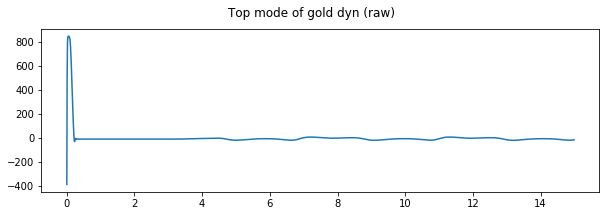

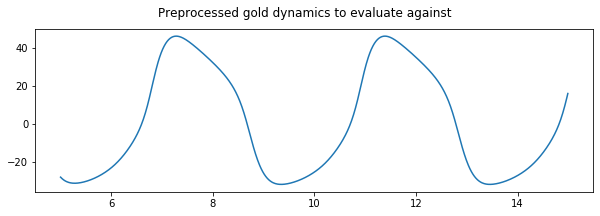

In [2]:
# Initial run
gold_dyn = dynamics.get_jimin_3neuron_dynamics(simul_ts, dt)
top_mode_gold_dyn = dynamics.get_top_mode(gold_dyn)
preprocessed_gold_dyn = distance.preprocess_pop_dyn(gold_dyn, eval_ts)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(simul_timepoints, top_mode_gold_dyn)
fig.suptitle("Top mode of gold dyn (raw)")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(eval_timepoints, preprocessed_gold_dyn)
fig.suptitle("Preprocessed gold dynamics to evaluate against")
_ = _

# Initial unoptimized dynamics

Total runtime = 0.13s
Initial error = 887.7761180177388


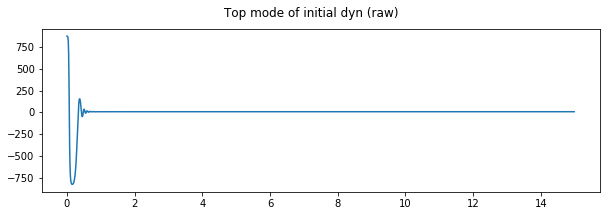

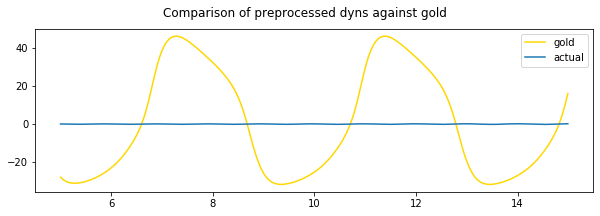

In [3]:
init_Gg, init_Gs, is_inhibitory = connectomes.get_random_connectome(N)
I_ext = dynamics.get_jimin_3neuron_Iext()
initial_dyn = dynamics.run_neural_model(N, init_Gg, init_Gs, is_inhibitory, I_ext, simul_ts, dt)

top_mode_initial_dyn = dynamics.get_top_mode(initial_dyn)
preprocessed_initial_dyn = distance.preprocess_pop_dyn(initial_dyn, eval_ts)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(simul_timepoints, top_mode_initial_dyn)
fig.suptitle("Top mode of initial dyn (raw)")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(eval_timepoints, preprocessed_gold_dyn, label="gold", c="gold")
ax.plot(eval_timepoints, preprocessed_initial_dyn, label="actual")
ax.legend()
fig.suptitle("Comparison of preprocessed dyns against gold")

error = distance.ts_distance_euclidean(preprocessed_gold_dyn, preprocessed_initial_dyn)
print("Initial error = " + str(error))
_ = _

# Perform optimization

In [11]:
def unpack_param_vec(x):
  gg_vec = x[:N*N]
  gs_vec = x[N*N:2*N*N]
  gg_mat = gg_vec.reshape(N,N)
  gs_mat = gs_vec.reshape(N,N)
  return gg_mat, gs_mat

def create_obj_fun(N, preprocessed_gold_dyn, eval_ts):
  def obj_fun(x):
    gg_mat, gs_mat = unpack_param_vec(x)
    pop_dyn = dynamics.run_neural_model(N, gg_mat, gs_mat, is_inhibitory, I_ext, simul_ts, dt)
    preprocessed_pop_dyn = distance.preprocess_pop_dyn(pop_dyn, eval_ts)
    error = distance.ts_distance_euclidean(preprocessed_gold_dyn, preprocessed_pop_dyn)
    return error
  return obj_fun

In [ ]:
from scipy.optimize import minimize

obj_fun = create_obj_fun(N, preprocessed_gold_dyn, eval_ts)
bnds = [(0, None)] * (2 * N**2)
init_cond_arr = np.concatenate([init_Gg.flatten(), init_Gs.flatten(),])

res = minimize(obj_fun, init_cond_arr, method='BFGS', bounds=bnds)
print(res)

# Compare optimized dynamics against golden

Total runtime = 0.16s
Optimized error = 887.8221214179569


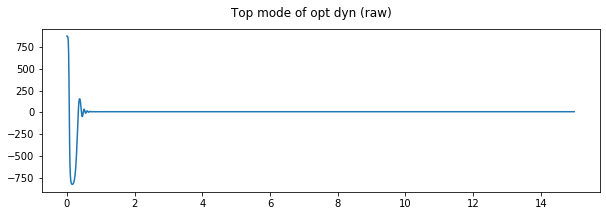

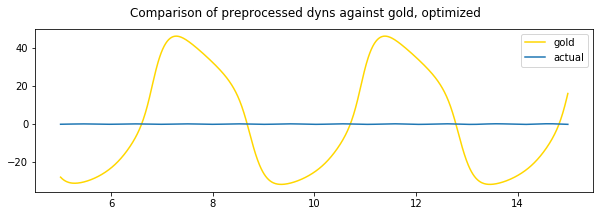

In [13]:
# Plot the optimized results
new_Gg, new_Gs = unpack_param_vec(res.x)

opt_dyn = dynamics.run_neural_model(N, new_Gg, new_Gs, is_inhibitory, I_ext, simul_ts, dt)

top_mode_opt_dyn = dynamics.get_top_mode(opt_dyn)
preprocessed_opt_dyn = distance.preprocess_pop_dyn(opt_dyn, eval_ts)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(simul_timepoints, top_mode_opt_dyn)
fig.suptitle("Top mode of opt dyn (raw)")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(eval_timepoints, preprocessed_gold_dyn, label="gold", c="gold")
ax.plot(eval_timepoints, preprocessed_opt_dyn, label="actual")
ax.legend()
fig.suptitle("Comparison of preprocessed dyns against gold, optimized")

error = distance.ts_distance_euclidean(preprocessed_gold_dyn, preprocessed_opt_dyn)
print("Optimized error = " + str(error))
_ = _